<a href="https://colab.research.google.com/github/tgubbe/NLPDisasterTweets/blob/main/NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Disaster Tweets**

In this session, I will attempt to create an accurate prediction model in order to determine if a tweet is disaster-related or is a normal tweet. This session was completed for a Kaggle competition, which can be found on the following link:

https://www.kaggle.com/competitions/nlp-getting-started

Before starting, there are many libraries and modules loaded in, including pandas, numpy, seaborn, and NLTK.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import string
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


The training and test data frames are loaded in:

In [4]:
train_df = pd.read_csv('/content/gdrive/My Drive/Datasets/train.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/Datasets/test.csv')

The trian data frame is viewed, as well as the info.

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


## **Exploratory Data Analysis**

Next, basic exploratory data analysis are completed, including viewing the data and creating charts to understand the data.

First, the missing values and duplicated values are viewed.

In [7]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
train_df.duplicated().sum()

0

There aren't any duplicated values in the training data frame, though there are missing values in the keyword and location columns.

Next, a value counts is run to see the most popular locations in the training data frame.

In [9]:
train_df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

There are two different variations of Unites States (USA and United States). This can be combined by replacing the USA count to 'United States'

In [10]:
#Replace the 'USA' entry names with 'United States'
train_df['location'] = train_df['location'].replace(['USA'], 'United States')

The value counts are re-run to see the value counts update.

This can be done for every value count and combine in various ways. Since I'll be using the 'target' and 'text' columns for analysis, I won't be looking to much further into the 'location' column.

In [11]:
train_df['location'].value_counts()

United States          154
New York                71
London                  45
Canada                  29
Nigeria                 28
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3340, dtype: int64

Next, the first 10 non-disaster tweets and first 10 disaster tweets are viewed to see the compisition of the tweets.

In [12]:
train_df[train_df['target'] == 0]['text'][:10]

15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
20          this is ridiculous....
21               London is cool ;)
22                     Love skiing
23           What a wonderful day!
24                        LOOOOOOL
Name: text, dtype: object

In [13]:
train_df[train_df['target'] == 1]['text'][:10]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7    I'm on top of the hill and I can see a fire in...
8    There's an emergency evacuation happening now ...
9    I'm afraid that the tornado is coming to our a...
Name: text, dtype: object

A countplot is created to see how many disaster and non-disaster tweets are in the training set data frame. 0 represents non-disaster tweets, while 1 represents disaster tweets.

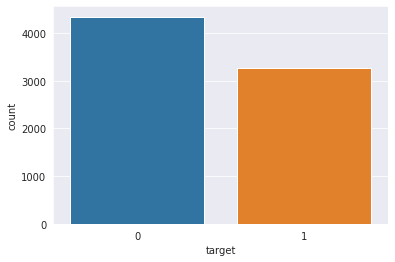

In [14]:
#Countplot created, where 0 = No Disaster and 1 = Disaster
sns.countplot(x = 'target', data = train_df)

Another way to view the proportion of disaster and non-disaster tweets is to use a pie chart. A pie chart is created to see another representation of the proportion of disaster and non-disaster tweets in the training data frame.

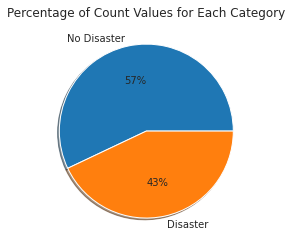

In [15]:
#Counts the amount of disasters and non-disasters from 'target'. 
sum_disaster = train_df['target'].value_counts()
#Adds color to pie chart
colors = sns.color_palette()[0:2]
label_values = ['No Disaster', 'Disaster']
#Plots pie chart
plt.pie(sum_disaster.values, labels = label_values, colors = colors, autopct = '%.0f%%', shadow = True)
plt.title('Percentage of Count Values for Each Category')
#Edit font size
plt.rcParams['font.size'] = 12

A histogram breakdown can also be created to see the word count distribution of both disaster and non-disaster (normal) tweets.

From the histogram, it appears the non-disaster tweet word counts are normally distributed, while the disaster tweet word counts may have a bimodal distribution.

Text(0, 0.5, 'Total Count')

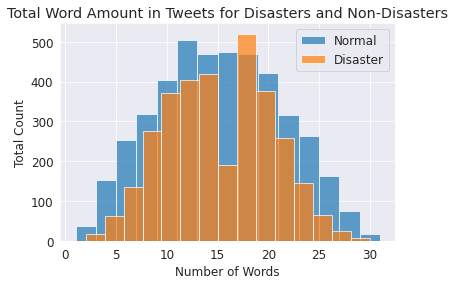

In [16]:
#New data frames are created, with one containing all of the non-disaster (normal) tweets and another containing all of the disaster tweets.
normal_tweet = train_df[train_df['target'] == 0]
disaster_tweet = train_df[train_df['target'] == 1]
#A histogram plot for word length is created for both normal and disaster tweets and combined on one plot.
plt.hist(normal_tweet['text'].apply(lambda x: len(x.split())), label = 'Normal', bins = 15, alpha = 0.7)
plt.hist(disaster_tweet['text'].apply(lambda x: len(x.split())), label = 'Disaster', bins = 15, alpha = 0.7)
#The title, legend, and labels are created for the histogram plot.
plt.title('Total Word Amount in Tweets for Disasters and Non-Disasters')
plt.legend()
plt.xlabel('Number of Words')
plt.ylabel('Total Count')

A histogram is also completed to see the character count of both disaster and normal tweets.

From the histograms, it appears disaster tweets have generally had a higher character count than normal tweets. Descriptive statistics and hypothesis testing could be done to confirm.

Text(0, 0.5, 'Total Count')

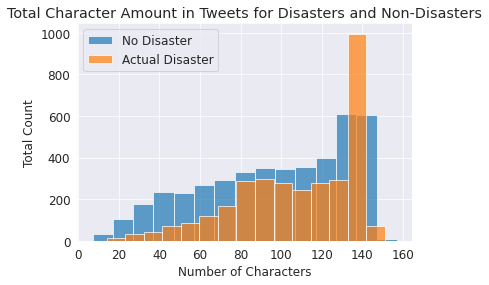

In [17]:
plt.hist(normal_tweet['text'].apply(lambda x: len(x)), label = 'No Disaster', bins = 15, alpha = 0.7)
plt.hist(disaster_tweet['text'].apply(lambda x: len(x)), label = 'Actual Disaster', bins = 15, alpha = 0.7)

plt.title('Total Character Amount in Tweets for Disasters and Non-Disasters')
plt.legend()
plt.xlabel('Number of Characters')
plt.ylabel('Total Count')

### **Creating a Text Cleaner**

After looking at the 'text' column in the train data frame, the text will need to be cleaned before analysis.

A text cleaner function, a remove emoji function, and a lemmatize function are created to clean the text, remove the emojis, and lemmatize the text in the tweets.

First, a set of stopwords are imported from the NLTK library. Stopwords are commonly used words that are usually removed in Natural Language Processing to help speed along the analysis. Stopwords include (but not limited to): a, an, and, he, her, and the.

In [18]:
#Creates the set of stopwords in the English language.
stop = set([w for w in nltk.corpus.stopwords.words('english')])

Next, the text cleaner function is created, which will be used to clean the text.

In [19]:
#Creates the text_cleaner function, which will be used to clean the text in the train_df dataframe.
def text_cleaner(text):
  #text = re.sub(r'MH370', 'Malaysia Airlines Flight 370', text) #Replaces MH370 with airline and flight number
  text = re.sub(r'http\S*\s?', '', text) #Removes URLs
  text = re.sub(r'\d+', '', text) #Removes numbers
  text = re.sub(r'[^\w\s]','', text) #Removes punctuation
  text = re.sub(r'http', '', text) #Removes http
  text = re.sub(r'wan', '', text) #Removes 'wan'
  text = re.sub(r'gon', '', text) #Removes 'gon'
  text = re.sub(r'&gt', '>', text) #Replaces gt with greater than symbol
  text = re.sub(r'&lt', '<', text) #Replaces lt with less than symbol
  text = re.sub(r'&amp;', '&', text) #Replaces &amp with ampersand symbol
  text = re.sub(r'\s+', ' ', text) #Removes extra whitespace
  text = ' '.join([i for i in text.split() if i not in stop])
  text = text.lower() #Makes all of the words lower case
  return text

In addition, a remove emoji function is created, which will be used to remove the emojis in the text. The code was created by GitHub user slowkow. The code can be found on the link below:

In [20]:
# Reference: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emojis = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emojis.sub(r'', text)

Next, a text lemmatizer is added to the text column. Lemmatization helps reduce words to a single form. 

In [21]:
#Calls the WordNetLemmetizer from NLTK library and saves in the lemmatizer variable.
lemmatizer = nltk.stem.WordNetLemmatizer()
#Creates the lemmatize function.
def lemmatize_text(text):
  text = ' '.join(lemmatizer.lemmatize(word) for word in text.split(' '))
  return text

### **Bigrams for Disaster and Normal Tweets**

The data will be checked for bigrams, which are a sequence of two consecutive elements from a string of tokens. An example would be a name ('John Doe') or phrase ('First Place').

First, the text cleaner and remove emoji functions are applied to the training_data data frame.

In [22]:
#The text cleaner and remove emoji functions are applied to the train_df data frame.
train_df['text'] = train_df['text'].apply(lambda x: text_cleaner(x))
train_df['text'] = train_df['text'].apply(lambda x: remove_emoji(x))
train_df['text'] = train_df['text'].apply(lambda x:lemmatize_text(x))
#The normal and disaster tweets data frames are set up.
normal_tweet = train_df[train_df['target'] == 0]
disaster_tweet = train_df[train_df['target'] == 1]

Next, a tokenizer needs to be implemented in order to break down the text into chunks. From this, a bigram model can be created to find the most common two consecutive tokens for both the normal and disaster tweets. The tokenizer and bigrams model are first completed for the normal tweets data frame. From the models, the bigrams are printed to view the 10 most popular bigrams.

In [23]:
normal_tokens = [w for c in normal_tweet['text']
                    for s in nltk.sent_tokenize(c)
                    for w in nltk.word_tokenize(s)
                    if w.isalpha() and w not in stop]

normal_bigrams = nltk.FreqDist(nltk.bigrams(normal_tokens))
normal_bigrams

FreqDist({('body', 'bag'): 46, ('cross', 'body'): 38, ('youtube', 'video'): 36, ('liked', 'youtube'): 35, ('look', 'like'): 32, ('feel', 'like'): 25, ('body', 'bagging'): 23, ('burning', 'building'): 23, ('full', 'read'): 22, ('reddit', 'quarantine'): 21, ...})

The same process is done for the disaster tweets data frame.

In [24]:
disaster_tokens = [w for c in disaster_tweet['text']
                    for s in nltk.sent_tokenize(c)
                    for w in nltk.word_tokenize(s)
                    if w.isalpha() and w not in stop]

disaster_bigrams = nltk.FreqDist(nltk.bigrams(disaster_tokens))
disaster_bigrams

FreqDist({('suicide', 'bomber'): 60, ('northern', 'california'): 41, ('oil', 'spill'): 38, ('california', 'wildfire'): 36, ('burning', 'building'): 35, ('suicide', 'bombing'): 34, ('bomber', 'detonated'): 30, ('confirmed', 'mh'): 29, ('yr', 'old'): 29, ('home', 'razed'): 29, ...})

A histogram is created to view the top 20 bigrams of the normal tweets in the training_df data frame.

[Text(0, 0.5, 'Bigram'),
 Text(0.5, 0, 'Count'),
 Text(0.5, 1.0, 'Top 20 Bigrams of Normal Tweets')]

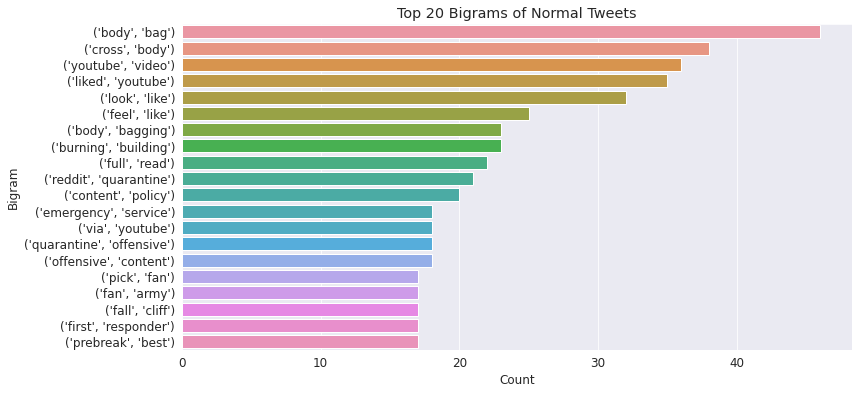

In [25]:
#Creates a counter for the disaster bigrams
freq_count_normal = Counter(normal_bigrams)
#Creates a new Pandas dataframe of the count
normal_count = pd.DataFrame(freq_count_normal.most_common(20))
#Creates a barplot of the top 20 Bigrams of Disaster Tweets
plt.figure(figsize=(12,6))
norm_plot = sns.barplot(x = normal_count[1], y = normal_count[0])
#Sets the labels in the barplot.
norm_plot.set(xlabel = 'Count', ylabel = 'Bigram', title = 'Top 20 Bigrams of Normal Tweets')

A histogram is also created for the top 20 bigrams of the disaster tweets in the training_df data frame.

[Text(0, 0.5, 'Bigram'),
 Text(0.5, 0, 'Count'),
 Text(0.5, 1.0, 'Top 20 Bigrams of Disaster Tweets')]

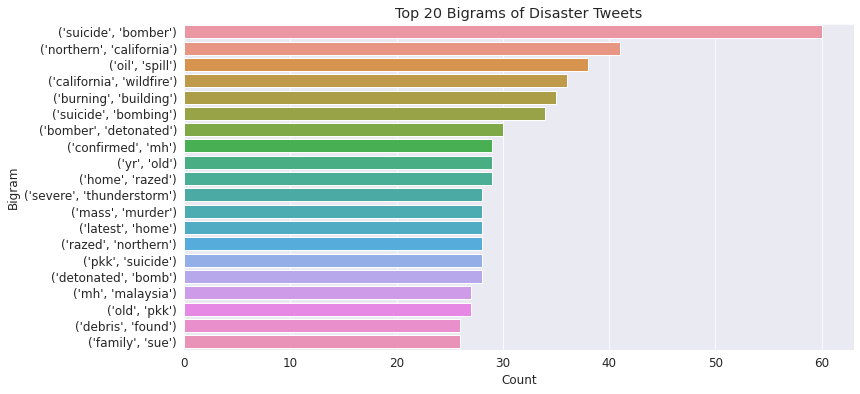

In [26]:
#Creates a counter for the disaster bigrams
freq_count_disaster = Counter(disaster_bigrams)
#Creates a new Pandas dataframe of the count
disaster_count = pd.DataFrame(freq_count_disaster.most_common(20))
#Creates a barplot of the top 20 Bigrams of Disaster Tweets
plt.figure(figsize=(12,6))
dis_plot = sns.barplot(x = disaster_count[1], y = disaster_count[0])
#Sets the labels in the barplot.
dis_plot.set(xlabel = 'Count', ylabel = 'Bigram', title = 'Top 20 Bigrams of Disaster Tweets')

Comparing the bigrams, there aren't any similarities between the disaster and normal tweets. In the disaster tweets, there are a few mentions of the MH Malaysia Flight 370 ('mh'), while the normal tweets top 20 bigrams there are a couple of combinations of 'body bag', including 'body bags' and 'body bagging'.

## **Prediction Models for Disaster Tweets**

Next, a couple of prediction models will be created to determine if the tweet is related to a disaster.

First, the modules that will be used for the prediction models are imported below:

In [27]:
from sklearn.feature_extraction.text import CountVectorizer #For Count Vectorizor.
from sklearn.model_selection import train_test_split #For train/test split.
from sklearn.linear_model import LogisticRegression #For Logistic Regression.
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

A Logistic Regression algorithm will be run first, followed by a Multinomial Bayes algorithm. Logistic Regression is a classification algorithm suited for binary classification problems, or yes/no problems.

The train/test data sets are created in a NumPy array, then split 70/30 (70% training set, 30% test set).

In [28]:
#X and y are created to return a NumPy array. 
X = train_df['text'].values
y = train_df['target'].values

In [29]:
#Train and test data set created.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

A Pipeline model using Count Vectorizor, Tf-Idf, and Logistic Regression is created. A Pipeline is used to apply multiple transformations to the data as well as apply a final estimator.

In [30]:
#Creates a pipeline for the Logistic Regression algorithm using Count Vectorizor and Tf-Idf.
pipeline_log = Pipeline([
    ('vect', CountVectorizer()),  #strings to token integer counts
    ('tfidf', TfidfTransformer()),  #integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  #train on TF-IDF vectors w/ Logistic Regression
])

The Pipeline Logistic Regression model is fit in the training set and the predictions are made based on the model.

In [31]:
pipeline_log.fit(X_train, y_train)

pipe_predict_log = pipeline_log.predict(X_test)

The confusion matrix and classification report are created to see how the model performed.

In [32]:
#Prints the confusion matrix and classification report for the logreg predictions.
print(confusion_matrix(y_test, pipe_predict_log))
print('\n')
print(classification_report(y_test, pipe_predict_log))

[[1193  125]
 [ 304  662]]


              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1318
           1       0.84      0.69      0.76       966

    accuracy                           0.81      2284
   macro avg       0.82      0.80      0.80      2284
weighted avg       0.82      0.81      0.81      2284



A confusion matrix plot is also created for a visualization on how well the model performed.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


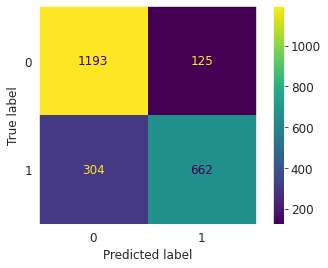

In [33]:
#Create confusion matrix plot.
plot_confusion_matrix(pipeline_log, X_test, y_test)
#Remove grid lines to clearly see the labels.
plt.grid(False)

From the confusion matrix and classification report, the model performed better predicting a normal tweet compared to a disaster tweet. The model still has a decent accuracy, with a total accuracy of 81%.

Another type of model that can be performed is the Multinomial Naive Bayes algorithm. The Multinomial Naive Bayes model is a popular choice for Natural Language Processing since it's suitable for classification of discrete features (e.g. text). Please see the following link for more information:

https://towardsdatascience.com/multinomial-na%C3%AFve-bayes-for-documents-classification-and-natural-language-processing-nlp-e08cc848ce6

A Pipeline model using Count Vectorizor, Tf-Idf, and Multinomial Naive Bayes is created.

In [34]:
pipeline_mb = Pipeline([
    ('vect', CountVectorizer()),  #strings to token integer counts
    ('tfidf', TfidfTransformer()),  #integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  #train on TF-IDF vectors w/ Naive Bayes classifier
])

The pipeline is then fit in the training set.

In [35]:
pipeline_mb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

Next, the prediction model for the Pipeline model is created.

In [36]:
pipe_predict_mb = pipeline_mb.predict(X_test)

The confusion matrix and classification report are created to see how the pipeline model performed.

In [37]:
print(confusion_matrix(y_test, pipe_predict_mb))
print('\n')
print(classification_report(y_test, pipe_predict_mb))

[[1192  126]
 [ 317  649]]


              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1318
           1       0.84      0.67      0.75       966

    accuracy                           0.81      2284
   macro avg       0.81      0.79      0.79      2284
weighted avg       0.81      0.81      0.80      2284



A confusion matrix plot is also created for a visualization on how well the model performed.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


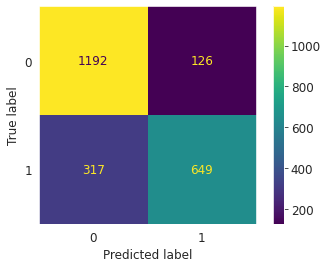

In [38]:
#Create confusion matrix plot.
plot_confusion_matrix(pipeline_mb, X_test, y_test)
#Remove grid lines to clearly see the labels.
plt.grid(False)

It appears the Multinomial Naive Bayes model did not perform any better than the Logistic Regression model. If anything, it appears the Multinomial Naive Bayes model performed a little worse.

## **Predict the Test Set**

The Logistic Regression Pipeline model will be applied to the provided test data set in order to predict normal and disaster tweets.

Before running the model, the functions created for the training data frame are applied to the testing data frame.

In [39]:
test_df['text'] = test_df['text'].apply(lambda x: text_cleaner(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_emoji(x))
test_df['text'] = test_df['text'].apply(lambda x:lemmatize_text(x))

The first five rows of the testing data frame are viewed.

In [40]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened terrible car crash
1,2,NaN,NaN,heard earthquake different city stay safe ever...
2,3,NaN,NaN,forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfire
4,11,NaN,NaN,typhoon soudelor kill china tai


The prediction model is run on the 'text' column in the testing data frame.

In [41]:
pipe_test_predict = pipeline_log.predict(test_df['text'])

The submission file is set up, the one column showing the ID and the other the target prediction score.

In [42]:
submission = test_df[['id']].reset_index(drop = True)

submission['target'] = pipe_test_predict.astype('int64')

Below is the setup of the submission data frame.

In [43]:
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,1
3261,10874,1


The submission is saved as a .csv file.

In [44]:
submission.to_csv('submission.csv', index = False)

## **Thank You**

Thank you for viewing my session. As stated, this session was used in a Kaggle competition to try to create an accurate prediction model.